# DNN classifier

reference data: https://labs.criteo.com/2013/12/download-terabyte-click-logs-2/

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import PreprocessingLayer, TextVectorization

### 1. Data batching

#### 1.1. Load dataset

In [2]:
LBL_COLUMN = ['lbl']
CAT_COLUMNS = [f'cat{i}' for i in range(26)]
NUM_COLUMNS = [f'num{i}' for i in range(13)]
COLUMNS = LBL_COLUMN + NUM_COLUMNS + CAT_COLUMNS
FEATURE_COLUMNS = NUM_COLUMNS + CAT_COLUMNS
COLUMN_DEFAULTS = [0]*14 + ['thisisdefault']*26

In [3]:
dataset = tf.data.experimental.make_csv_dataset(
    file_pattern='data/dac/sample_train.txt', 
    batch_size=200,
    num_epochs=1,
    column_defaults=COLUMN_DEFAULTS,
    column_names=COLUMNS, 
    label_name='lbl', 
    field_delim='\t',
    shuffle=True
)\
.shuffle(10, reshuffle_each_iteration=False)

#### 1.2. Conbine the columes

In [4]:
class FeaturesExtraction:
    
    def __init__(self, num_col, feature_type=None):
        self.num_col = num_col
        self.feature_type = feature_type

    def __call__(self, features, labels):
        numeric_features = [features.pop(col) for col in self.num_col]
        numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
        numeric_features = tf.stack(numeric_features, axis=-1)
        
        if self.feature_type == 'cat':
            return features
        if self.feature_type == 'numeric':
            return numeric_features
        if self.feature_type == 'no_label':
            features['numeric'] = numeric_features
            return features
        else:
            features['numeric'] = numeric_features
            return features, labels


In [5]:
packed_dataset = dataset.map(FeaturesExtraction(num_col=NUM_COLUMNS))

#### 1.3. Training / validation split

In [6]:
def is_validate(idx, data):
    return idx % 5 == 0

def is_train(idx, data):
    return not is_validate(idx, data)

recover = lambda idx, data: data

validate_dataset = packed_dataset.enumerate()\
.filter(is_validate)\
.map(recover)

train_dataset = packed_dataset.enumerate()\
.filter(is_train)\
.map(recover)

### 2. Data processing

In [7]:
class DataProcessingLayer(PreprocessingLayer):
    
    def __init__(self, ls_cat_col, num_col, name=None):
        
        super(DataProcessingLayer, self).__init__(name=name)
        self._ls_cat_col = ls_cat_col
        self._num_col = num_col
        self._dict_vectorization_layer = dict()
        for key in ls_cat_col:
            self._dict_vectorization_layer.update({
                key: TextVectorization(output_sequence_length=1)
            })
        self.processing_layer = None
    
    def adapt(self, data):
        
        for cat_col in self._ls_cat_col:
            tmp_dataset = data.map(lambda feature, label: feature.pop(cat_col))
            self._dict_vectorization_layer[cat_col].adapt(tmp_dataset)
    
    def build(self, input_shape):
        
        dict_cat_vocab = dict()
        ls_feature_cat_col = list()
        ls_feature_num_col = list()
        
        for cat_col in self._ls_cat_col:
            dict_cat_vocab.update({
                cat_col: self._dict_vectorization_layer[cat_col].get_vocabulary()
            })
        
        for cat_col, vocab in dict_cat_vocab.items():
            tf_cat_vocab = tf.feature_column.categorical_column_with_vocabulary_list(
                key=cat_col, vocabulary_list=vocab)
            ls_feature_cat_col.append(tf.feature_column.indicator_column(tf_cat_vocab))
        
        tf_feature_num = tf.feature_column.numeric_column(self._num_col, shape=input_shape[self._num_col].as_list()[-1])
        ls_feature_num_col.append(tf_feature_num)
        
        self.processing_layer = tf.keras.layers.DenseFeatures(
            ls_feature_cat_col + ls_feature_num_col)
        
    def call(self, inputs):
        
        return self.processing_layer(inputs)
        

In [8]:
data_processing_layer = DataProcessingLayer(
    ls_cat_col=CAT_COLUMNS,
    num_col='numeric',
    name='data_processing_layer'
)

In [9]:
data_processing_layer.adapt(data=train_dataset)

### 3. ANN Model Building

In [10]:
ann_model_input = {
    'numeric': tf.keras.Input((len(NUM_COLUMNS),), dtype=tf.dtypes.float32, name=f'numeric_input')
}

for cat_column in CAT_COLUMNS:
    ann_model_input.update({cat_column: tf.keras.Input((1,), dtype=tf.dtypes.string, name=f'{cat_column}_input')})

x = data_processing_layer(ann_model_input)
x = tf.keras.layers.Dense(128, activation="relu", name='hiden_layer_1')(x)
x = tf.keras.layers.Dense(128, activation="relu", name='hiden_layer_2')(x)
ann_model_output = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(x)

ann_model = tf.keras.Model(
    inputs=ann_model_input, 
    outputs=ann_model_output, 
    name='binary_classifer')

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

ann_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=METRICS)

In [11]:
ann_model.summary()

Model: "binary_classifer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat0_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat1_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat10_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat11_input (InputLayer)        [(None, 1)]          0                                            
___________________________________________________________________________________

### 5. Training

In [12]:
model_history = ann_model.fit(
    train_dataset, 
    validation_data=validate_dataset, 
    epochs=20, 
    workers=4)

Epoch 1/20
48/48 [==============================] - 3s 63ms/step - loss: 0.6865 - tp: 228.0000 - fp: 0.0000e+00 - tn: 7624.0000 - fn: 1699.0000 - accuracy: 0.8221 - precision: 1.0000 - recall: 0.1183 - auc: 0.5648 - val_loss: 0.6786 - val_tp: 93.0000 - val_fp: 0.0000e+00 - val_tn: 1901.0000 - val_fn: 406.0000 - val_accuracy: 0.8308 - val_precision: 1.0000 - val_recall: 0.1864 - val_auc: 0.5932
Epoch 2/20
48/48 [==============================] - 1s 26ms/step - loss: 0.6769 - tp: 416.0000 - fp: 2.0000 - tn: 7628.0000 - fn: 1505.0000 - accuracy: 0.8422 - precision: 0.9952 - recall: 0.2166 - auc: 0.6181 - val_loss: 0.6741 - val_tp: 123.0000 - val_fp: 0.0000e+00 - val_tn: 1915.0000 - val_fn: 362.0000 - val_accuracy: 0.8492 - val_precision: 1.0000 - val_recall: 0.2536 - val_auc: 0.6361
Epoch 3/20
48/48 [==============================] - 1s 26ms/step - loss: 0.6728 - tp: 513.0000 - fp: 0.0000e+00 - tn: 7640.0000 - fn: 1398.0000 - accuracy: 0.8536 - precision: 1.0000 - recall: 0.2684 - auc: 0.

In [13]:
def fitting_plot(fitting_history, 
                 metrics):
    
    plt.figure(figsize=(10,5))
    plt.plot(fitting_history.history[metrics])
    plt.plot(fitting_history.history[f'val_{metrics}'])
    plt.title(f'model {metrics}')
    plt.ylabel(metrics)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

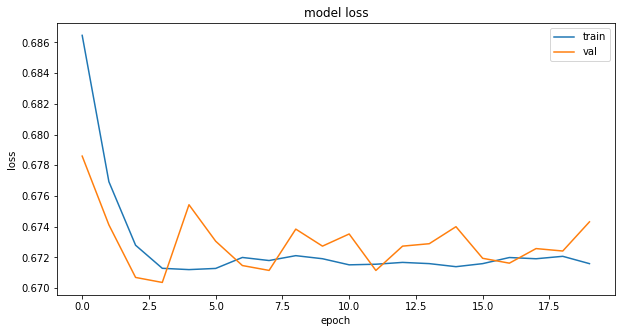

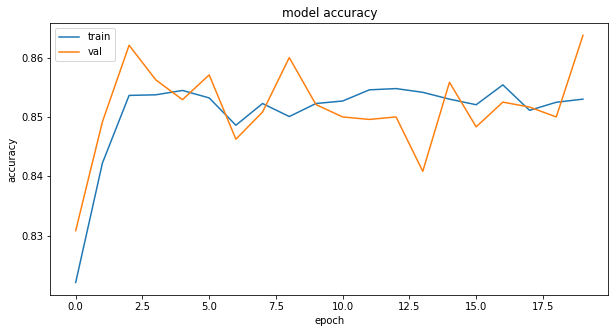

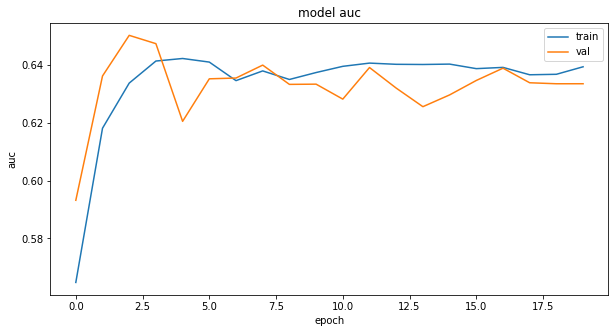

In [14]:
for metrics in ['loss', 'accuracy', 'auc']:
    fitting_plot(fitting_history=model_history, metrics=metrics)

### 6. Evaluation

#### 6.1 Load testing dataset

In [15]:
testing_dataset = tf.data.experimental.make_csv_dataset(
    file_pattern='data/dac/sample_test.txt', 
    batch_size=200,
    num_epochs=1,
    column_defaults=COLUMN_DEFAULTS,
    column_names=COLUMNS, 
    label_name='lbl', 
    field_delim='\t',
    shuffle=True
).shuffle(10, reshuffle_each_iteration=False)

In [16]:
testing_packed_dataset = testing_dataset.map(FeaturesExtraction(num_col=NUM_COLUMNS))

In [17]:
ann_model.evaluate(testing_packed_dataset, return_dict=True, verbose=0)

{'loss': 0.6718186140060425,
 'tp': 671.0,
 'fp': 0.0,
 'tn': 9513.0,
 'fn': 1767.0,
 'accuracy': 0.8521462678909302,
 'precision': 1.0,
 'recall': 0.27522560954093933,
 'auc': 0.6376128196716309}